<img src="https://classic.d2l.ai/_images/seq2seq.svg" />

In [ ]:
# download template
!wget https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py -O d2l.py

--2022-07-17 08:24:59--  https://gist.githubusercontent.com/b1nch3f/b702d2ebfd2c751aa21b68c7425e0d4e/raw/c77225291924a8d2c33c210d74f2744210b6b716/d2l.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59707 (58K) [text/plain]
Saving to: ‘d2l.py’

d2l.py              100%[===================>]  58.31K  --.-KB/s    in 0.001s  

2022-07-17 08:24:59 (69.6 MB/s) - ‘d2l.py’ saved [59707/59707]



In [ ]:
import collections
import math
import tensorflow as tf
import d2l

### Encoder

$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})$

$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)$



In [ ]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(*kwargs)
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        output = self.rnn(X, **kwargs)
        state = output[1:]
        return output[0], state

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X, training=False)
output.shape

TensorShape([4, 7, 16])

In [ ]:
len(state), [element.shape for element in state]

(2, [TensorShape([4, 16]), TensorShape([4, 16])])

### Decoder

$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1})$

In [ ]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def call(self, X, state, **kwargs):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = tf.repeat(tf.expand_dims(state[-1], axis=1), repeats=X.shape[1], axis=1)
        X_and_context = tf.concat((X, context), axis=2)
        rnn_output = self.rnn(X_and_context, state, **kwargs)
        output = self.dense(rnn_output[0])
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` is a list with `num_layers` entries. Each entry has shape:
        # (`batch_size`, `num_hiddens`)
        return output, rnn_output[1:]

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state, training=False)
output.shape, len(state), state[0].shape

(TensorShape([4, 7, 10]), 2, TensorShape([4, 16]))

<img src="https://classic.d2l.ai/_images/seq2seq-details.svg" />

### Loss Function

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen, dtype=tf.float32)[
        None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [ ]:
X = tf.ones((2,3,4))
sequence_mask(X, tf.constant([1, 2]), value=-1)

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.]],

       [[ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.],
        [-1., -1., -1., -1.]]], dtype=float32)>

In [ ]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, valid_len):
        super().__init__(reduction='none')
        self.valid_len = valid_len

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype=tf.float32)
        weights = sequence_mask(weights, self.valid_len)
        label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss

In [ ]:
loss = MaskedSoftmaxCELoss(tf.constant([4, 2, 0]))
loss(tf.ones((3,4), dtype = tf.int32), tf.ones((3, 4, 10))).numpy()

array([2.3025851, 1.1512926, 0.       ], dtype=float32)

### Training

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    animator = d2l.Animator(xlabel="epoch", ylabel="loss",
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x for x in batch]
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']] * Y.shape[0]),
                             shape=(-1, 1))
            dec_input = tf.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, X_valid_len, training=True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            gradients = d2l.grad_clipping(gradients, 1)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            metric.add(tf.reduce_sum(l), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.026, 1502.6 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7fb1c63aeaf0>


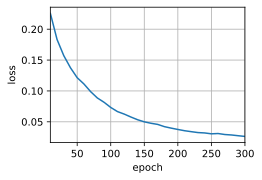

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

### Prediction

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    save_attention_weights=False):
    """Predict for sequence to sequence."""
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = tf.constant([len(src_tokens)])
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = tf.expand_dims(src_tokens, axis=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len, training=False)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state, training=False)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred.numpy())
    return ' '.join(tgt_vocab.to_tokens(tf.reshape(output_seq, shape = -1).numpy().tolist())), attention_weight_seq

### Evaluation of Predicted Sequences

$\exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n}$

In [ ]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j’ai payé ., bleu 0.000
he's calm . => il est paresseux ., bleu 0.658
i'm home . => je suis calme !, bleu 0.418
